In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from torch.utils.data import DataLoader, TensorDataset
import torch
import chardet
import torch.nn as nn
import torch.optim as optim
import shap

In [2]:
df = pd.read_csv('data/projectdata_new.csv')

In [3]:
NUMERICAL_FILL = -999
CATEGORICAL_FILL = "Missing"

# Impute missing values with different constants based on data type
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:  # For numerical columns
        df[col].fillna(NUMERICAL_FILL, inplace=True)
    elif df[col].dtype == 'object':  # For categorical columns
        df[col].fillna(CATEGORICAL_FILL, inplace=True)


In [4]:
# Split features and target
features = df.drop(['n_under_age10', 'n_fam_members', 'region', 'GENDER_RESP', 'AGE_RESP', 'HOUSE_TYPE', 'HOUSE_TYPE2', 'working_status', 'reason_not_working', 'working_field', 'unique_identifier', 'REASON_TIRED2', ], axis=1)
target = df['n_under_age10']

In [5]:
# Identifying categorical and numerical columns
categorical_cols = [col for col in features.columns if features[col].dtype == 'object']
numerical_cols = [col for col in features.columns if features[col].dtype in ['int64', 'float64']]

In [6]:
# Creating column transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

In [7]:
# Apply transformations
X = preprocessor.fit_transform(features)
y = target.values

In [8]:
# Convert arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

In [9]:
# Create data loaders
dataset = TensorDataset(X_tensor, y_tensor)
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
def train_model(model, train_loader):
    model.train()
    for epoch in range(10):  # number of epochs
        for data, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

train_model(model, train_loader)


Epoch 1, Loss: 0.08321340382099152
Epoch 2, Loss: 0.08778110891580582
Epoch 3, Loss: 0.43351662158966064
Epoch 4, Loss: 0.09168240427970886
Epoch 5, Loss: 0.12588340044021606
Epoch 6, Loss: 0.17979247868061066
Epoch 7, Loss: 0.049863118678331375
Epoch 8, Loss: 0.07304759323596954
Epoch 9, Loss: 0.057173363864421844
Epoch 10, Loss: 0.06217990815639496


In [16]:
def evaluate_model(model, test_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, targets in test_loader:
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    print(f'Average Loss: {total_loss / len(test_loader)}')

evaluate_model(model, test_loader)



Average Loss: 1.1064532190561294


In [ ]:
shap.initjs()

def f(X):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(X, dtype=torch.float32)
        output = model(input_tensor)
        # Flatten output if necessary (important for ensuring compatibility with SHAP)
        return output.numpy().flatten()

# Ensure the transformed data and the feature names match in dimension
X_transformed = preprocessor.transform(features.iloc[:100])

# Get correct feature names after transformation
feature_names = preprocessor.get_feature_names_out()

# Initialize SHAP explainer with the model prediction function and a sample of the transformed data
explainer = shap.KernelExplainer(f, X_transformed)

# Calculate SHAP values for the transformed data
shap_values = explainer.shap_values(X_transformed)

# Plotting SHAP values; ensure that the feature names and the data used here match the transformed data
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)


In [18]:
assert shap_values.shape[1] == X_transformed.shape[1], "Mismatch in number of SHAP values and features"
shap.initjs()

  0%|          | 0/100 [00:00<?, ?it/s]

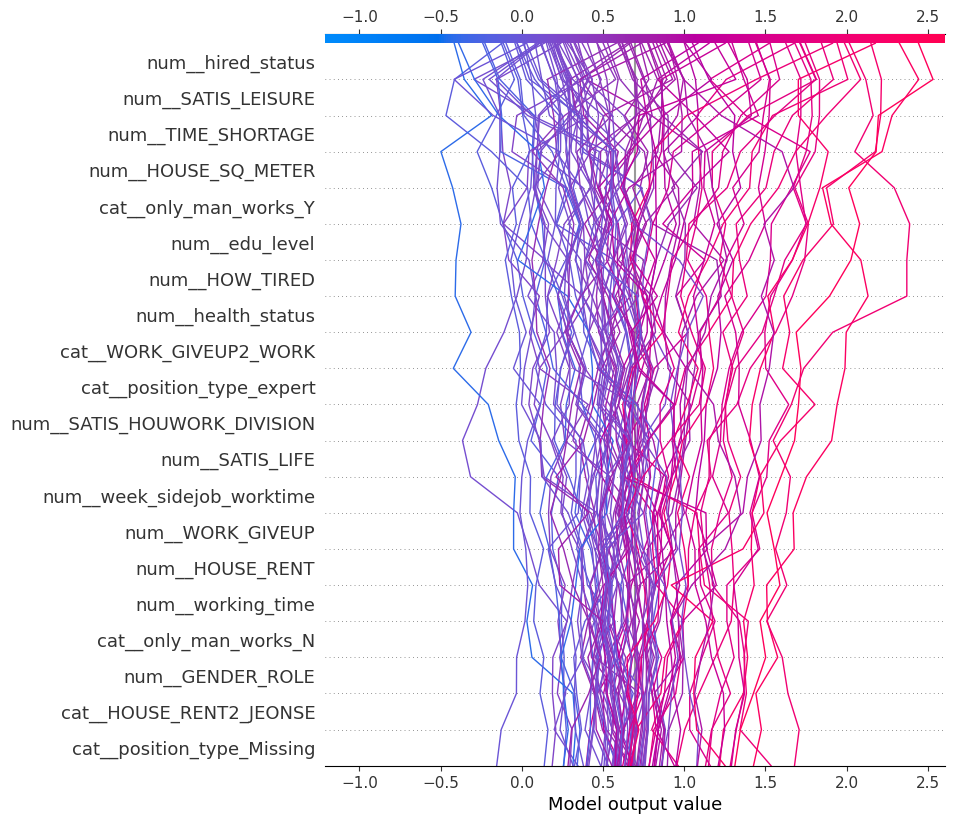

In [18]:
# Initialize SHAP explainer with the model prediction function and a sample of the transformed data
explainer = shap.KernelExplainer(f, X_transformed)

# Calculate SHAP values for the transformed data
shap_values = explainer.shap_values(X_transformed)

assert shap_values.shape[1] == X_transformed.shape[1], "Mismatch in number of SHAP values and features"
expected_value = explainer.expected_value
if isinstance(expected_value, np.ndarray):
    expected_value = expected_value[0] 
shap.decision_plot(expected_value, shap_values, X_transformed[:100], feature_names=feature_names)

In [ ]:
def train_and_evaluate(n_iterations=100):
    # Assuming 'features' and 'preprocessor' are predefined
    X_transformed = preprocessor.transform(features.iloc[:100])  # Preprocessed data
    feature_names = preprocessor.get_feature_names_out()  # Feature names from preprocessor

    all_shap_values = []

    for i in range(n_iterations):
        model = Net()
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Function to predict output for SHAP
        def predict_model(X):
            model.eval()
            with torch.no_grad():
                # Convert to tensor, specifying device and dtype
                input_tensor = torch.tensor(X, dtype=torch.float32)
                output = model(input_tensor)
                return output.numpy().flatten()  # Flatten for compatibility with SHAP

        # Train the model
        model.train()
        for epoch in range(10):
            for data, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(data)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

        # Setup SHAP explainer using the predict function
        explainer = shap.KernelExplainer(predict_model, X_transformed)
        shap_values = explainer.shap_values(X_transformed)
        all_shap_values.append(shap_values)

    # Average the SHAP values
    average_shap_values = np.mean(all_shap_values, axis=0)
    return average_shap_values, X_transformed, feature_names

# Run the training and evaluation
average_shap_values, X_transformed, feature_names = train_and_evaluate()

# Plotting the summary SHAP plot
shap.summary_plot(average_shap_values, features=X_transformed, feature_names=feature_names)

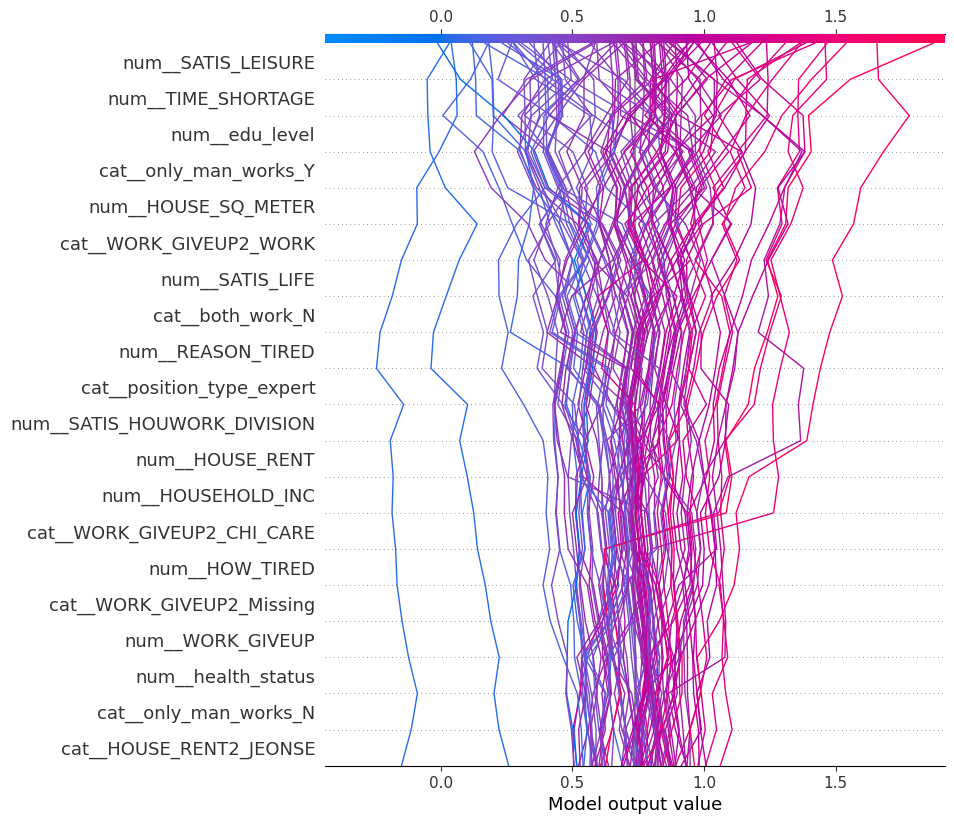

In [25]:

expected_value = explainer.expected_value
if isinstance(expected_value, np.ndarray):
    expected_value = expected_value[0]
    
shap.decision_plot(expected_value, average_shap_values, X_transformed[:100], feature_names=feature_names)
